# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.datasets import fetch_california_housing

# Import Data

In [2]:
data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)

df['MedianHouseValue'] = data.target

In [3]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


# Feature Selection 

In [4]:
numerical_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target = 'MedianHouseValue'

# Train Test Split

In [5]:
X = df[numerical_features]
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Outlier Removal

In [ ]:
# for this data set removing the outliers using the IQR method had worse results 
# because we are removing house prices that are actual values in the real world, I should try a softer IQR or remove outliers manually

In [7]:
# # only on the training set!!!
# train_data = X_train.copy()
# train_data['target'] = y_train

# Q1 = train_data.quantile(0.25)
# Q3 = train_data.quantile(0.75)
# IQR = Q3 - Q1
# mask = ~((train_data < (Q1 - 1.5 * IQR)) | (train_data > (Q3 + 1.5 * IQR))).any(axis=1)
# train_data_clean = train_data[mask]

In [8]:
# X_train = train_data_clean.drop(columns=['target'])
# y_train = train_data_clean['target']

# Numerical Transformers

In [7]:
numeric_transformer = Pipeline(steps=[
    ('mean_imputer', SimpleImputer(strategy='mean')),  # Impute with mean
    ('scaler', StandardScaler())  # Scale with StandardScaler
])

# Categorical Transformers

In [8]:
# DOES NOT APPLY

# Preprocessing Pipeline

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_transformer', numeric_transformer, numerical_features),
    ])

# Modeling Functions

In [10]:
def show_results(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'mape': mape, 'r2': r2}

In [11]:
def get_output_df(X_test, y_pred, y_test):
    df_compare = X_test.copy()
    
    df_compare['pred'] = y_pred
    df_compare['target'] = y_test.values

    df_compare['absolute_error'] = (df_compare['pred'] - df_compare['target']).abs()
    
    return df_compare

In [12]:
# function to plot the feature importances of tree based algorithms
def show_feature_importances(model):
    feature_importances = model.named_steps['regressor'].feature_importances_
    features_names = model.named_steps['preprocessor'].get_feature_names_out()
    
    importance_df = pd.DataFrame({
        'Feature': features_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(importance_df)
    
    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.tight_layout()

In [13]:
# Variable that stores the test scores of the different models to decide which one to use
report_ac = {}

# Modeling Parametrizations

In [14]:
metric_to_optimize = 'neg_mean_squared_error'

In [15]:
param_grid_lr = {
    # Linear Regression has no hyperparameters
}

param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]
}

param_grid_lasso = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

param_grid_elastic_net = {
    'regressor__alpha': [0.01, 0.1, 1, 10],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

param_grid_svr = {
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.01, 0.1, 0.5],
    'regressor__kernel': ['linear', 'rbf']
}

param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 10],
    'regressor__weights': ['uniform', 'distance']
}

param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__alpha': [0.0001, 0.001, 0.01],
    'regressor__learning_rate': ['constant', 'adaptive']
}

param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [5, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5]
}

# Linear Regression

In [16]:
lr_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [17]:
grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [18]:
grid_search_lr.fit(X_train, y_train)

lr_model = grid_search_lr.best_estimator_

y_pred_lr = lr_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [19]:
print("Best hyperparameters:", grid_search_lr.best_params_)

results = show_results(y_test, y_pred_lr)
print(results)

report_ac['lr'] = results

Best hyperparameters: {}
{'mae': 0.5394785312622641, 'mse': 0.5329663253426207, 'rmse': 0.7300454269034364, 'mape': 0.3206848533781706, 'r2': 0.6039371734371024}


In [20]:
#get_output_df(X_test, y_pred_lr, y_test)

# Ridge Regression

In [21]:
ridge_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

In [22]:
grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid_ridge,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [23]:
grid_search_ridge.fit(X_train, y_train)

ridge_model = grid_search_ridge.best_estimator_

y_pred_ridge = ridge_model.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [24]:
print("Best hyperparameters:", grid_search_ridge.best_params_)

results = show_results(y_test, y_pred_ridge)
print(results)

report_ac['ridge'] = results

Best hyperparameters: {'regressor__alpha': 0.01}
{'mae': 0.5394784496365689, 'mse': 0.5329663485565691, 'rmse': 0.7300454428024115, 'mape': 0.3206847033290567, 'r2': 0.60393715618614}


# Lasso Regression

In [25]:
lasso_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

In [26]:
grid_search_lasso = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid_lasso,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [27]:
grid_search_lasso.fit(X_train, y_train)

lasso_model = grid_search_lasso.best_estimator_

y_pred_lasso = lasso_model.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [28]:
print("Best hyperparameters:", grid_search_lasso.best_params_)

results = show_results(y_test, y_pred_lasso)
print(results)

report_ac['lasso'] = results

Best hyperparameters: {'regressor__alpha': 0.01}
{'mae': 0.5432101926211537, 'mse': 0.5399218025046013, 'rmse': 0.7347937142522392, 'mape': 0.3219897836841136, 'r2': 0.5987683554201352}


# Elastic Net

In [29]:
elastic_net_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

In [30]:
grid_search_elastic_net = GridSearchCV(
    estimator=elastic_net_model,
    param_grid=param_grid_elastic_net,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [31]:
grid_search_elastic_net.fit(X_train, y_train)

elastic_net_model = grid_search_elastic_net.best_estimator_

y_pred_elastic_net = elastic_net_model.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [32]:
print("Best hyperparameters:", grid_search_elastic_net.best_params_)

results = show_results(y_test, y_pred_elastic_net)
print(results)

report_ac['elastic_net'] = results

Best hyperparameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}
{'mae': 0.542751816329915, 'mse': 0.5392288628133357, 'rmse': 0.7343220429847763, 'mape': 0.3217027722016911, 'r2': 0.5992832991224111}


# SVR

In [33]:
svr_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

In [34]:
grid_search_svr = GridSearchCV(
    estimator=svr_model,
    param_grid=param_grid_svr,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [35]:
grid_search_svr.fit(X_train, y_train)

svr_model = grid_search_svr.best_estimator_

y_pred_svr = svr_model.predict(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [36]:
print("Best hyperparameters:", grid_search_svr.best_params_)

results = show_results(y_test, y_pred_svr)
print(results)

report_ac['svr'] = results

Best hyperparameters: {'regressor__C': 10, 'regressor__epsilon': 0.1, 'regressor__kernel': 'rbf'}
{'mae': 0.3827127020604216, 'mse': 0.33516708336793616, 'rmse': 0.5789361651926196, 'mape': 0.2068302429328307, 'r2': 0.7509275612784546}


# KNN Regressor

In [37]:
knn_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

In [38]:
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid_knn,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [39]:
grid_search_knn.fit(X_train, y_train)

knn_model = grid_search_knn.best_estimator_

y_pred_knn = knn_model.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [40]:
print("Best hyperparameters:", grid_search_knn.best_params_)

results = show_results(y_test, y_pred_knn)
print(results)

report_ac['knn'] = results

Best hyperparameters: {'regressor__n_neighbors': 10, 'regressor__weights': 'distance'}
{'mae': 0.4389242746856218, 'mse': 0.4140555725293534, 'rmse': 0.6434715009457321, 'mape': 0.23990838320782437, 'r2': 0.6923032232764963}


# MLP Regressor

In [41]:
mlp_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor())
])

In [42]:
grid_search_mlp = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid_mlp,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [43]:
grid_search_mlp.fit(X_train, y_train)

mlp_model = grid_search_mlp.best_estimator_

y_pred_mlp = mlp_model.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
print("Best hyperparameters:", grid_search_mlp.best_params_)

results = show_results(y_test, y_pred_mlp)
print(results)

report_ac['mlp'] = results

Best hyperparameters: {'regressor__activation': 'tanh', 'regressor__alpha': 0.0001, 'regressor__hidden_layer_sizes': (100, 50), 'regressor__learning_rate': 'constant'}
{'mae': 0.3530551477430627, 'mse': 0.28443617494015866, 'rmse': 0.5333255806167173, 'mape': 0.19823509078837187, 'r2': 0.7886271794918425}


# Random Forest Regressor

In [45]:
rf_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [46]:
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [47]:
grid_search_rf.fit(X_train, y_train)

rf_model = grid_search_rf.best_estimator_

y_pred_rf = rf_model.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [48]:
print("Best hyperparameters:", grid_search_rf.best_params_)

results = show_results(y_test, y_pred_rf)
print(results)

report_ac['rf'] = results

Best hyperparameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
{'mae': 0.33051571810056235, 'mse': 0.25978068964460416, 'rmse': 0.5096868544946045, 'mape': 0.1847165989734849, 'r2': 0.8069493899807691}


# Gradient Booster Regressor

In [49]:
gb_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

In [50]:
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid_gb,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [51]:
grid_search_gb.fit(X_train, y_train)

gb_model = grid_search_gb.best_estimator_

y_pred_gb = gb_model.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [52]:
print("Best hyperparameters:", grid_search_gb.best_params_)

results = show_results(y_test, y_pred_gb)
print(results)

report_ac['gb'] = results

Best hyperparameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
{'mae': 0.314234239326412, 'mse': 0.23422028536745668, 'rmse': 0.4839631033120776, 'mape': 0.1765897758839115, 'r2': 0.825944072167471}


In [53]:
pd.set_option('display.max_rows', None)

get_output_df(X_test, y_pred_gb, y_test).sort_values(by=['absolute_error'], ascending=False)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,pred,target,absolute_error
19542,1.7679,39.0,5.000000,0.888889,22.0,2.444444,37.63,-120.92,0.921619,4.50000,3.578381
16642,0.7025,19.0,2.425197,1.125984,1799.0,2.833071,35.30,-120.67,1.582182,5.00001,3.417828
15288,3.5341,15.0,5.681710,1.059382,747.0,1.774347,33.10,-117.31,1.757940,5.00001,3.242070
10415,3.3750,4.0,3.769953,1.169014,815.0,1.913146,33.65,-117.58,1.764084,5.00001,3.235926
9850,1.2656,19.0,3.791908,1.156069,248.0,1.433526,36.60,-121.89,1.855292,5.00000,3.144708
17819,1.7361,42.0,3.000000,1.000000,26.0,1.857143,37.39,-121.90,1.871571,5.00001,3.128439
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06,1.455267,4.37500,2.919733
15311,1.9891,26.0,4.606704,1.279330,1703.0,1.902793,33.19,-117.38,2.152993,5.00000,2.847007
15705,2.6607,52.0,3.123134,1.113184,1202.0,1.495025,37.79,-122.42,3.696805,0.87500,2.821805
6639,1.1667,52.0,2.477477,1.108108,273.0,2.459459,34.15,-118.15,2.184561,5.00001,2.815449


In [56]:
report_ac

{'lr': {'mae': 0.5062122870930769,
  'mse': 0.7432838059222492,
  'rmse': 0.8621390873416245,
  'mape': 0.3027531398871115,
  'r2': 0.4335735105120082},
 'ridge': {'mae': 0.506212209588343,
  'mse': 0.7432819232665488,
  'rmse': 0.8621379954894395,
  'mape': 0.3027529333712205,
  'r2': 0.4335749452076799},
 'lasso': {'mae': 0.5061498725628173,
  'mse': 0.7421762966220323,
  'rmse': 0.8614965447533915,
  'mape': 0.30266297731458874,
  'r2': 0.4344174985015201},
 'elastic_net': {'mae': 0.5057111681737924,
  'mse': 0.7139131878145201,
  'rmse': 0.8449338363531905,
  'mape': 0.30060176828732277,
  'r2': 0.4559556692194907},
 'svr': {'mae': 0.43877043876020644,
  'mse': 0.435498551172412,
  'rmse': 0.6599231403522777,
  'mape': 0.24019727892090761,
  'r2': 0.6681241895057518},
 'knn': {'mae': 0.46796559791804104,
  'mse': 0.44311347134613194,
  'rmse': 0.6656676883747115,
  'mape': 0.2597323744491722,
  'r2': 0.662321167204762},
 'mlp': {'mae': 0.39031703785261296,
  'mse': 0.33124683971414

                       Feature  Importance
0      num_transformer__MedInc    0.449943
7   num_transformer__Longitude    0.151729
6    num_transformer__Latitude    0.143396
5    num_transformer__AveOccup    0.139976
2    num_transformer__AveRooms    0.044018
1    num_transformer__HouseAge    0.039983
4  num_transformer__Population    0.016488
3   num_transformer__AveBedrms    0.014468


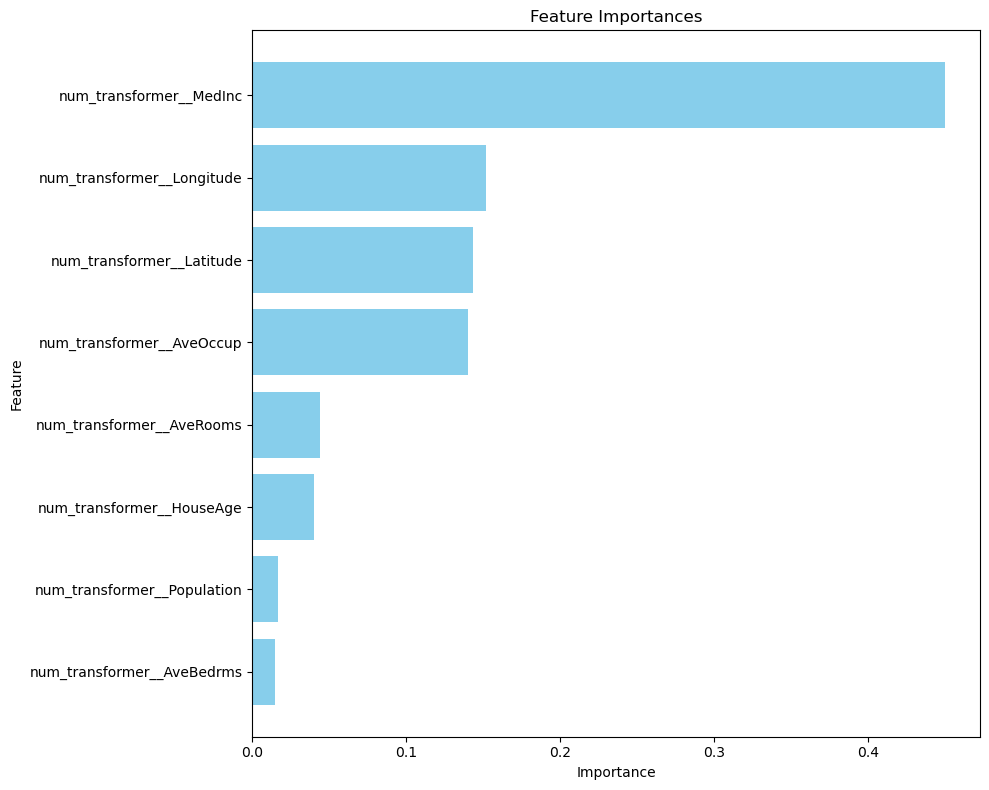

In [57]:
show_feature_importances(gb_model)

                       Feature  Importance
0      num_transformer__MedInc    0.436297
5    num_transformer__AveOccup    0.145346
7   num_transformer__Longitude    0.118266
6    num_transformer__Latitude    0.110318
2    num_transformer__AveRooms    0.064812
1    num_transformer__HouseAge    0.058595
4  num_transformer__Population    0.035126
3   num_transformer__AveBedrms    0.031240


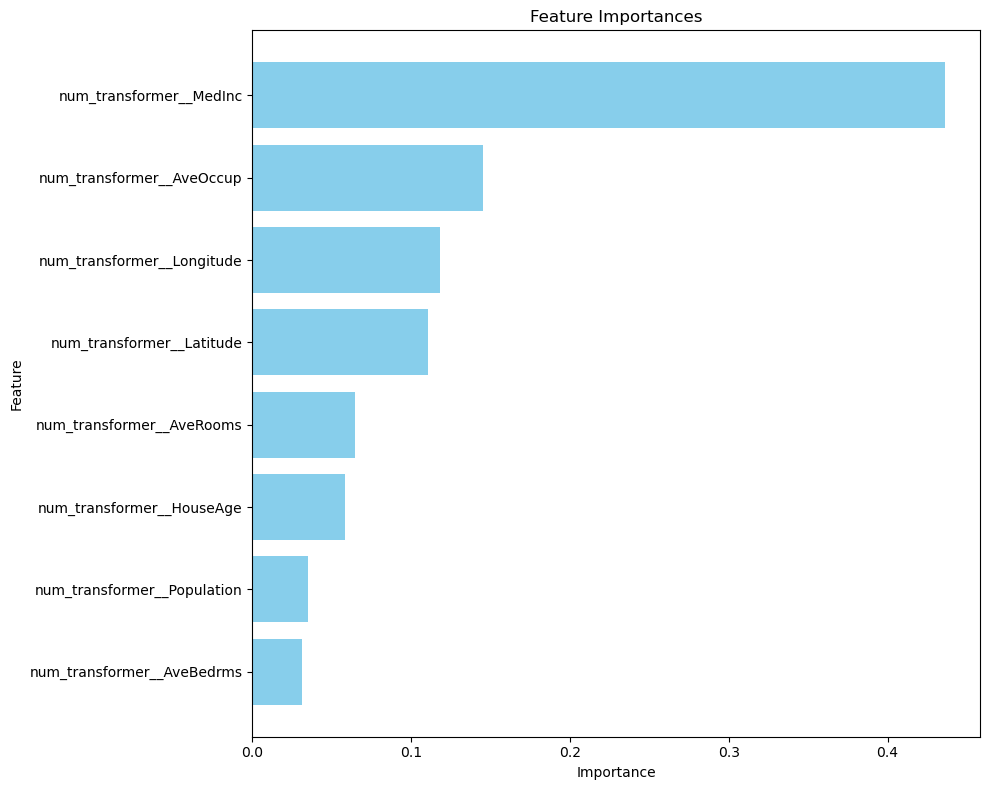

In [58]:
show_feature_importances(rf_model)

In [ ]:
# Future work
# using latitude and longitude, create a feature that represents the location of the block
#     it can be either distance to the sea, or using districts names or other additional information other than using coordinates as numbers